In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [93]:
df = pd.read_csv('AirPassengers.csv')
df.columns = ['Date', 'Passengers']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.head()

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [77]:
train = df[df['Date'] <= '1960-01-01']
test = df[df['Date'] >= '1960-01-01']

del train['Date'], test['Date']

In [78]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')

In [79]:
df.index = df['Date']

In [80]:
del df['Date']

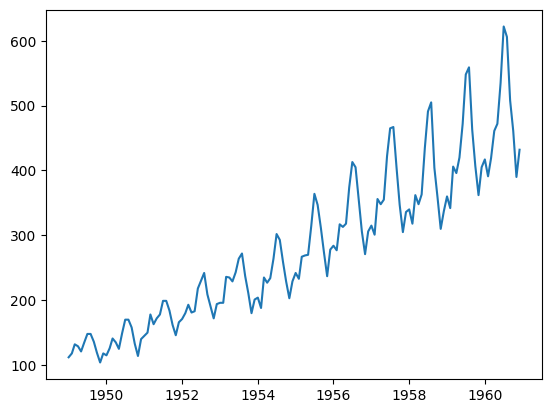

In [81]:
plt.plot(df)
plt.show()

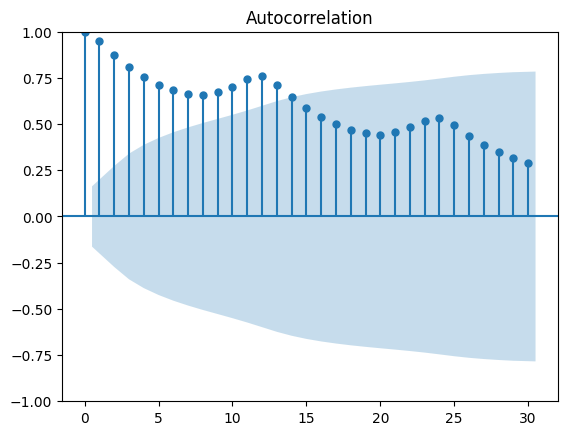

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Passengers'], lags=30)
plt.show()

C:\python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


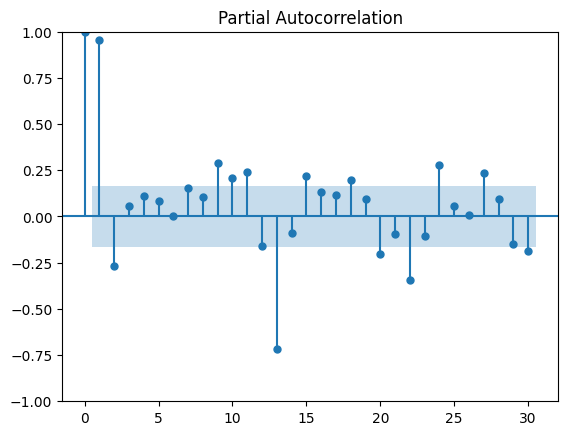

In [84]:
plot_pacf(df['Passengers'], lags=30)
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller


def stationary(value):
    
    res = adfuller(value)

    print(f'T-statistic: {res[0]:.3f} p_value: {res[1]:.3f}')

    if res[1] < 0.05:
        print('Stationary')
    else:
        print('Not Stationary')
        
stationary(df['Passengers'])

T-statistic: 0.815 p_value: 0.992
Not Stationary


--------------------

###### Делание разностей (d)

In [16]:
df['Passengers_diff'] = df['Passengers'].diff()

In [17]:
stationary(df['Passengers_diff'].dropna())

T-statistic: -2.829 p_value: 0.054
Not Stationary


In [18]:
df['Passengers_diff_2'] = df['Passengers'].diff(periods=2)

In [19]:
stationary(df['Passengers_diff_2'].dropna())

T-statistic: -2.962 p_value: 0.039
Stationary


###### Выбор параметров p и q

##### p (авторегрессия) и q (скользящее среднее),

<Figure size 1200x500 with 0 Axes>

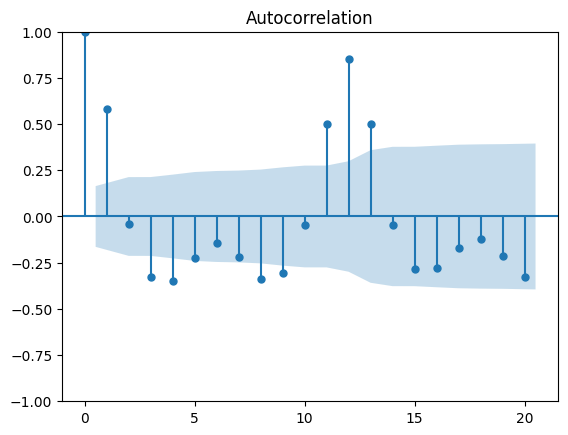

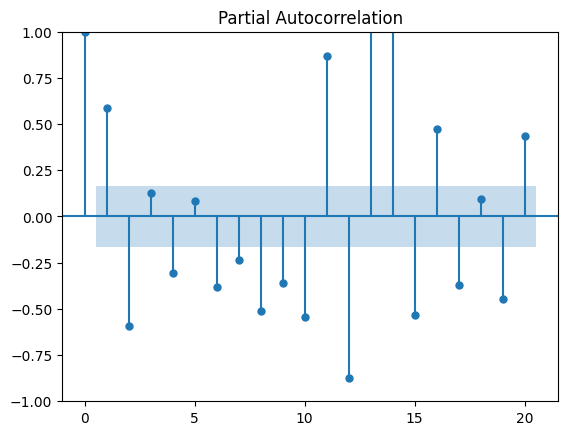

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(df['Passengers_diff_2'].dropna(), lags=20)
plot_pacf(df['Passengers_diff_2'].dropna(), lags=20)
plt.show()

--------------------

In [57]:
from itertools import product

p = q = range(1, 40)

d = range(1, 5)

In [58]:
pdq = list(product(p, d, q))

In [71]:
import pandas as pd

# Данные
data = {'Date': pd.date_range(start='2023-01-01', periods=10, freq='D'),
        'Sales': [10, 15, 18, 25, 30, 50, 60, 55, 40, 35]}

df = pd.DataFrame(data)
df.set_index('Date', inplace=True)  # Дата в индекс

# Скользящее среднее с окном 3
df['SMA_3'] = df['Sales'].rolling(window=3).mean()

print(df)


            Sales      SMA_3
Date                        
2023-01-01     10        NaN
2023-01-02     15        NaN
2023-01-03     18  14.333333
2023-01-04     25  19.333333
2023-01-05     30  24.333333
2023-01-06     50  35.000000
2023-01-07     60  46.666667
2023-01-08     55  55.000000
2023-01-09     40  51.666667
2023-01-10     35  43.333333


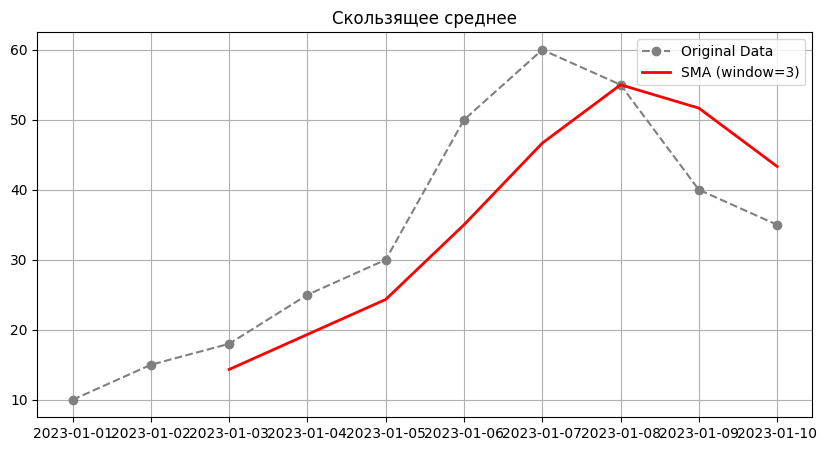

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], label='Original Data', linestyle='dashed', marker='o', color='gray')
plt.plot(df.index, df['SMA_3'], label='SMA (window=3)', linewidth=2, color='red')

plt.legend()
plt.title("Скользящее среднее")
plt.grid()
plt.show()


------

In [2]:
from statsmodels.tsa.ar_model import AutoReg

In [13]:
np.random.seed(42)
n = 100  # Количество точек
y = [0, 0]  # Начальные значения (нужны для лагов)
for t in range(2, n):
    y_t = 0.5 * y[t-1] + 0.2 * y[t-2] + np.random.normal(0, 1)  # AR(2)
    y.append(y_t)

In [15]:
df = pd.DataFrame({"Time": pd.date_range('2000-01-01', periods=100), 'Value': y})

df.tail()

,Time,Value
95,2000-04-05,-0.124316
96,2000-04-06,-0.467085
97,2000-04-07,-1.721921
98,2000-04-08,-0.658257
99,2000-04-09,-0.412457


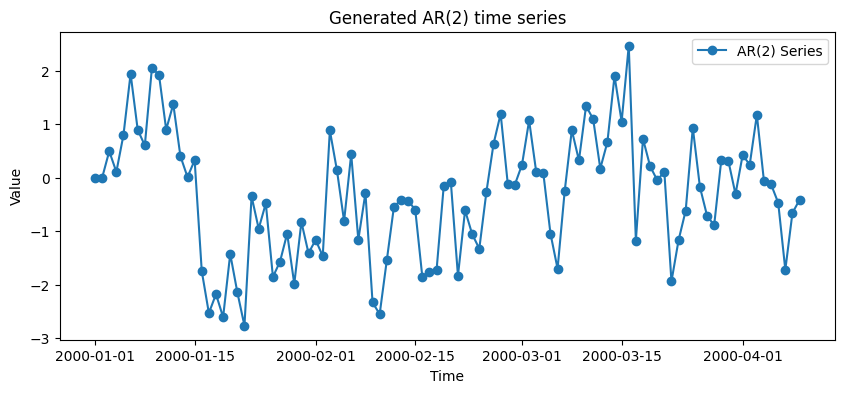

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(df['Time'], df['Value'], marker='o', linestyle='-', label='AR(2) Series')
plt.title('Generated AR(2) time series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [17]:
model = AutoReg(df['Value'], lags=2)
model_fit = model.fit()

In [18]:
y_pred = model_fit.predict(start=0, end=n-1)

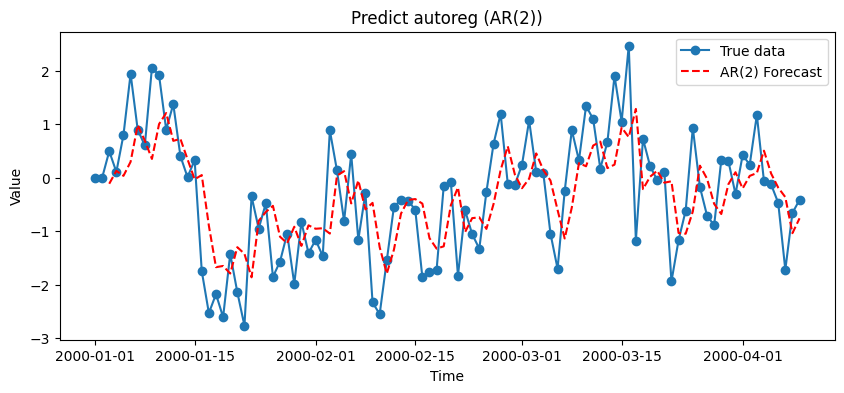

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(df['Time'], df["Value"], marker='o', linestyle='-', label='True data')
plt.plot(df['Time'], y_pred, linestyle='--', color='red', label='AR(2) Forecast')
plt.title('Predict autoreg (AR(2))')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

------------

In [22]:
df.columns = ['Date', 'y']

In [23]:
df.head()

,Date,y
0,2000-01-01,0.000000
1,2000-01-02,0.000000
2,2000-01-03,0.496714
3,2000-01-04,0.110093
4,2000-01-05,0.802078


In [37]:
###🔹 Создаем матрицу лагов вручную

p = 2
X = np.column_stack([df['y'].shift(i) for i in range(1, p+1)])
Y = df['y'][p:]

X = X[p:, :]

In [47]:
# 🔹 Решаем OLS: (X^T * X)^(-1) * X^T * Y

X = np.column_stack([np.ones(len(X)), X])

coeff = np.linalg.inv(X.T @ X) @ X.T @ Y

print(f'Estimates coeff {coeff}')

Estimates coeff [-0.07634226  0.07451684  0.4856772   0.1899036 ]


In [61]:
X.T @ X @ X.T @ Y

array([-11565.56883983, -11565.56883983,  21558.9504443 ,  20642.12713189])

In [49]:
y_pred = X @ coeff

In [52]:
df['y'].shape

(100,)

In [53]:
y_pred.shape

(98,)

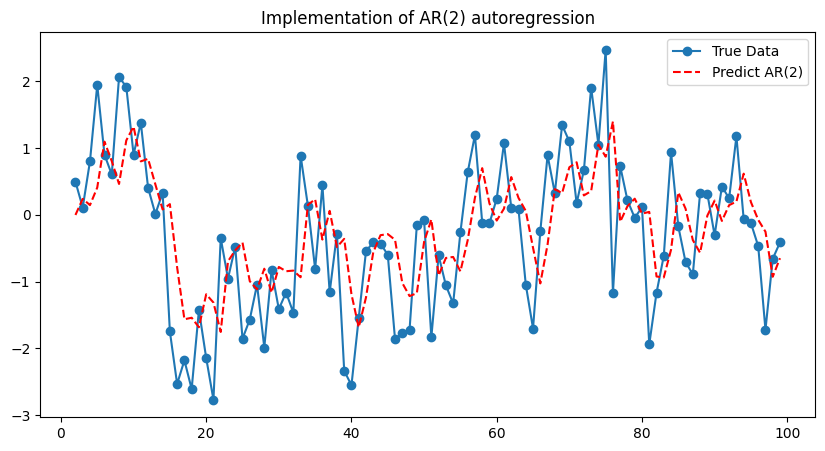

In [55]:
plt.figure(figsize=(10 ,5))
plt.plot(range(p, n), df['y'][p:], label='True Data', marker='o')
plt.plot(range(p, n), y_pred, label='Predict AR(2)', linestyle='--', color='r')
plt.legend()
plt.title('Implementation of AR(2) autoregression')
plt.show()

-------

In [11]:
maxtrix_a = np.array([[1, 2],
                     [3, 4]])

maxtrix_a

array([[1, 2],
       [3, 4]])

In [12]:
### находим апределитель

defe = (1 * 4) - (3 * 2)
defe

-2

In [13]:
### матрица миноров

minor_matrix = np.array([[4, 3],
                        [2, 1]])

In [14]:
## Находим матрицу алгебраических дополнений

M = np.array([[4, -3],
              [-2, 1]])

## Находим транспонированную матрицу алгебраических дополнений.

MT = M.T

MT

array([[ 4, -2],
       [-3,  1]])

In [33]:
#### обратная матрица 

m_1 = -1/2 * maxtrix_a  @ MT
m_1

array([[1., 0.],
       [0., 1.]])

-----------

In [3]:
b = np.array([[2, 5, 7],
              [6, 3, 4],
              [5, -2, -3]])

In [5]:
#### Определитель 

np.linalg.det(b)

-1.0000000000000284

In [6]:
#### минор для --> [2]  (3 * (-3) - (-2) * 4) = -1
#### минор для --> [5]  (6 * (-3) - (5) * 4) = -38
#### минор для --> [7]  (6 * (-2) - (5) * 3) = -27

In [7]:
M = np.array([[-1, -38, -27],
              [-1, -41, -29],
              [-1, -34, -24]])
M

array([[ -1, -38, -27],
       [ -1, -41, -29],
       [ -1, -34, -24]])

In [10]:
### СМЕНИТЬ ЗНАКИ  

## 1 - 1
## - 1 -
## 1 - 1

B_ = np.array([[-1, -38, 27],
               [-1,  41, -29],
               [-1, -34, 24]])


BT = B_.T
BT

array([[ -1,  -1,  -1],
       [-38,  41, -34],
       [ 27, -29,  24]])

In [9]:
np.linalg.inv(b)

array([[  1.,  -1.,   1.],
       [-38.,  41., -34.],
       [ 27., -29.,  24.]])

In [72]:
B_1 = 1/-1 * BT

In [73]:
b @ B_1

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

--------

In [17]:
#############  ARIMA

In [121]:
df.index = df['Date']
del df['Date']
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


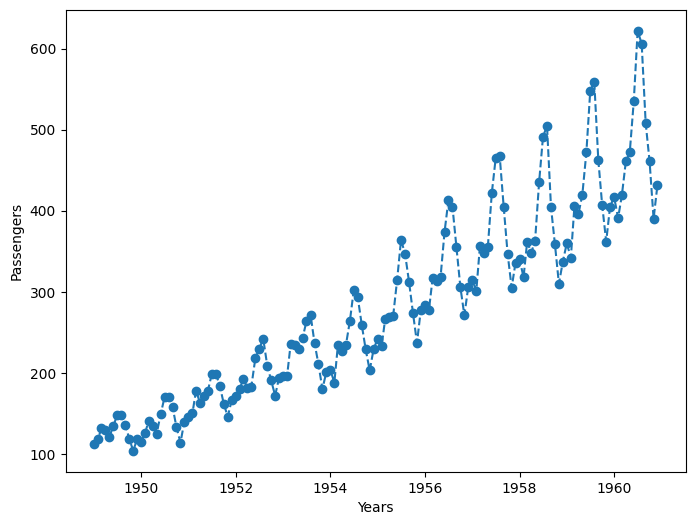

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(df, marker='o', linestyle='--')
plt.ylabel('Passengers')
plt.xlabel('Years')
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

warnings.filterwarnings('ignore')



def stationary_test(x):
    stat, p, lags, ods, crit, y = adfuller(x)
    stat2, p2, lags2, crit2 = kpss(x)

    print(f'Dickey-Fuller: {p:.3f}')
    print(f' Kwiatkowski-Phillips-Schmidt-Shin: {p2:.3f} \n')
    print('adfuller')
    print(f'T-statistiv: {stat:.3f} | T-critic in level {crit}')

    if p > 0.05:
        print('| NOT stationary |\n')
    else:
        print('| Stationary |\n')

    
    print('kpss test')
    print(f'KPSS TES | T-statistiv: {stat2:.3f} | T-critic in level: {crit2}')
    if p2 < 0.05:
        print('| NOT stationary |')
    else:
        print('| Stationary |')
    
stationary_test(df)

Dickey-Fuller: 0.992
 Kwiatkowski-Phillips-Schmidt-Shin: 0.010 

adfuller
T-statistiv: 0.815 | T-critic in level {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
| NOT stationary |

kpss test
KPSS TES | T-statistiv: 1.651 | T-critic in level: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
| NOT stationary |


In [6]:
X = df.diff().dropna()

In [7]:
stationary_test(X)

Dickey-Fuller: 0.054
 Kwiatkowski-Phillips-Schmidt-Shin: 0.100 

adfuller
T-statistiv: -2.829 | T-critic in level {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
| NOT stationary |

kpss test
KPSS TES | T-statistiv: 0.024 | T-critic in level: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
| Stationary |


In [8]:
X = X.diff(periods=2).dropna()

In [9]:
stationary_test(X)

Dickey-Fuller: 0.000
 Kwiatkowski-Phillips-Schmidt-Shin: 0.082 

adfuller
T-statistiv: -15.834 | T-critic in level {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
| Stationary |

kpss test
KPSS TES | T-statistiv: 0.389 | T-critic in level: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
| Stationary |


In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1000x600 with 0 Axes>

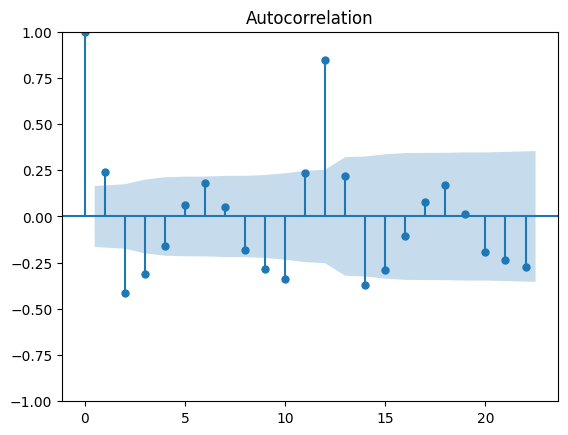

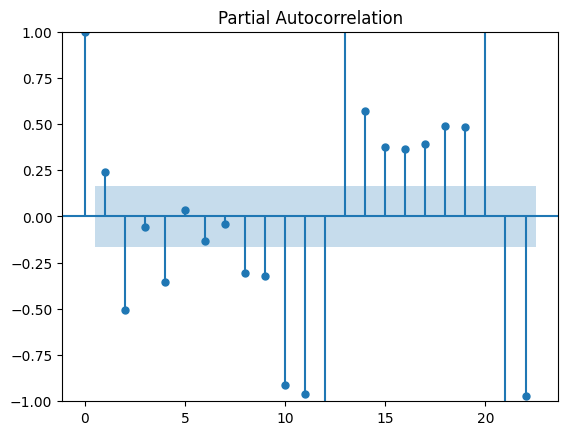

In [12]:
plt.figure(figsize=(10, 6))
plot_acf(X)
plot_pacf(X)
plt.show()

In [130]:
##### Подбор оптимальных параметров (p, d, q) для модели ARIMA по AIC/BIC
diff = df['Passengers'].diff(periods=2).dropna()

res = adfuller(train)

p_value = res[1]


d = 0 if p_value < 0.05 else 1

p_values = range(0, 4)
q_values = range(0, 4)

best_aic = float('inf')
best_bic = float('inf')
best_order = None

In [131]:
from itertools import product

for p, q in product(p_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        result = model.fit()
        aic = result.aic
        bic = result.bic
        
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            
        if bic < best_bic:
            best_bic = bic
        
        print(f"ARIMA -> {p} | {d} | {q} - AIC -> {aic:.3f}, BIC -> {bic:.3f}")
    except:
        continue
        
        
print(f"\n Best model from AIC -> {best_order}")

ARIMA -> 0 | 1 | 0 - AIC -> 1294.543, BIC -> 1297.433
ARIMA -> 0 | 1 | 1 - AIC -> 1281.090, BIC -> 1286.870
ARIMA -> 0 | 1 | 2 - AIC -> 1279.558, BIC -> 1288.229
ARIMA -> 0 | 1 | 3 - AIC -> 1279.337, BIC -> 1290.899
ARIMA -> 1 | 1 | 0 - AIC -> 1284.971, BIC -> 1290.752
ARIMA -> 1 | 1 | 1 - AIC -> 1274.456, BIC -> 1283.127
ARIMA -> 1 | 1 | 2 - AIC -> 1270.755, BIC -> 1282.317
ARIMA -> 1 | 1 | 3 - AIC -> 1272.157, BIC -> 1286.609
ARIMA -> 2 | 1 | 0 - AIC -> 1280.415, BIC -> 1289.086
ARIMA -> 2 | 1 | 1 - AIC -> 1265.299, BIC -> 1276.860
ARIMA -> 2 | 1 | 2 - AIC -> 1245.123, BIC -> 1259.575
ARIMA -> 2 | 1 | 3 - AIC -> 1277.927, BIC -> 1295.269
ARIMA -> 3 | 1 | 0 - AIC -> 1278.847, BIC -> 1290.409
ARIMA -> 3 | 1 | 1 - AIC -> 1266.904, BIC -> 1281.356
ARIMA -> 3 | 1 | 2 - AIC -> 1260.457, BIC -> 1277.799
ARIMA -> 3 | 1 | 3 - AIC -> 1234.524, BIC -> 1254.757

 Best model from AIC -> (3, 1, 3)


In [122]:
train = df.iloc[:-10]
test = df.iloc[-10:]

test

,Passengers
Date,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [132]:
from sklearn.metrics import mean_absolute_error

predict = result.predict(start='1960-03-01', end='1960-12-01')

print(mean_absolute_error(predict, test))

44.11533059588692


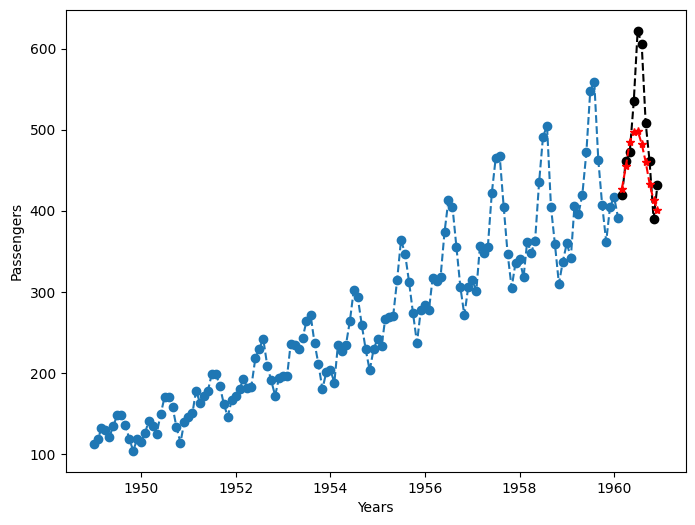

In [136]:
plt.figure(figsize=(8, 6))
plt.plot(train, marker='o', linestyle='--')
plt.plot(test, marker='o', linestyle='--', c='black')
plt.plot(predict, marker='*', linestyle='--', c='r')
plt.ylabel('Passengers')
plt.xlabel('Years')
plt.show()

---------

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [70]:
x, y = make_classification(n_samples=100, n_features=1, n_classes=2,
                          n_clusters_per_class=1, n_informative=1,
                          n_redundant=0, n_repeated=0, random_state=1, weights=[0.2, 0.8])

df = pd.DataFrame(x, index=pd.date_range(start='2025-01-01', periods=100))
df.head()

,0
2025-01-01,-1.659028
2025-01-02,-0.642029
2025-01-03,-1.539190
2025-01-04,0.659137
2025-01-05,-0.468458


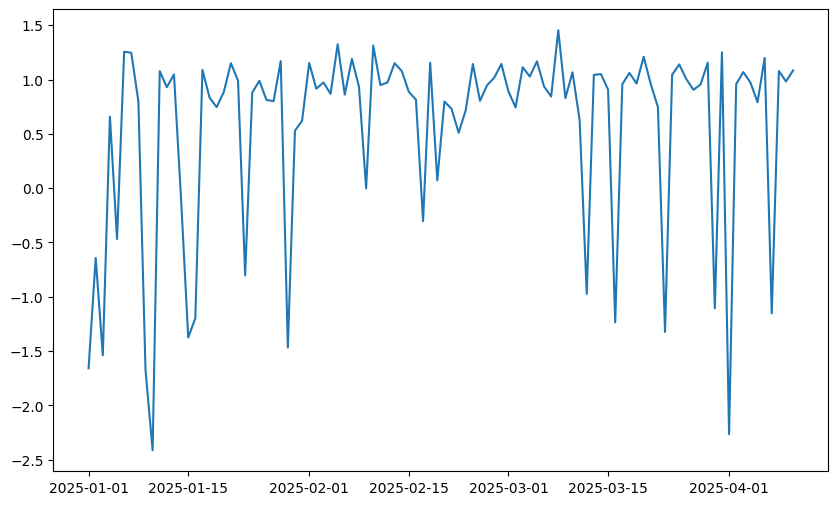

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.show()

In [72]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationary(x):
    
    test_1 = adfuller(x)
    test_2 = kpss(x)
    
    print(f'adfuller test | t-statistiv {test_1[0]:.3f}  | p_value {test_1[1]:.3f} |')
    
    for p, v in test_1[4].items():
        print(f'critical values: {p} - {v:.3f}')
    
    print(f'kpss test     | t-statistiv {test_2[0]:.3f}   | p_value {test_2[1]:.3f}|')
    
        
    for p, v in test_2[3].items():
        print(f'critical values: {p} - {v:.3f}')
    
    
    if test_1[1] < 0.05:
        print('NOT Stationary')
    else:
        print('Stationary')
        
    if test_2[1] > 0.05:
        print('Stationary')
    else:
        print('NOT Stationary')
    
    
test_stationary(x)

adfuller test | t-statistiv -9.106  | p_value 0.000 |
critical values: 1% - -3.498
critical values: 5% - -2.891
critical values: 10% - -2.583
kpss test     | t-statistiv 0.514   | p_value 0.039|
critical values: 10% - 0.347
critical values: 5% - 0.463
critical values: 2.5% - 0.574
critical values: 1% - 0.739
NOT Stationary
NOT Stationary


<Figure size 1000x600 with 0 Axes>

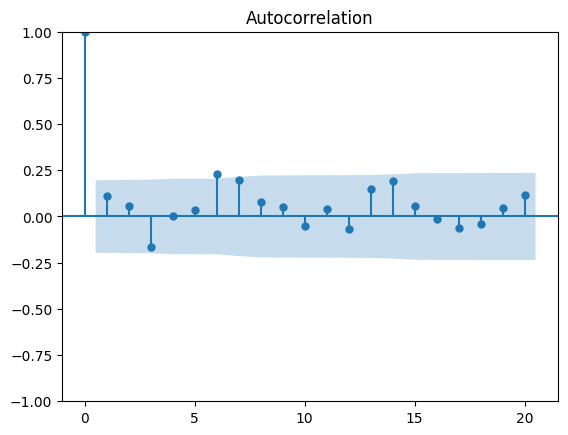

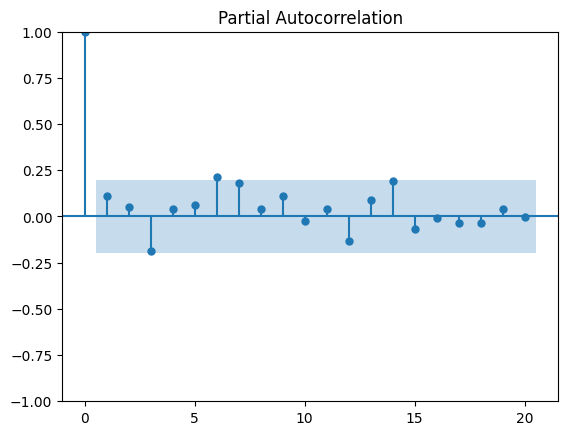

In [73]:
plt.figure(figsize=(10, 6))
plot_acf(df)
plot_pacf(df)
plt.show()

In [113]:
diff = df.diff(2).dropna()

test_stationary(diff)

adfuller test | t-statistiv -4.845  | p_value 0.000 |
critical values: 1% - -3.509
critical values: 5% - -2.896
critical values: 10% - -2.585
kpss test     | t-statistiv 0.176   | p_value 0.100|
critical values: 10% - 0.347
critical values: 5% - 0.463
critical values: 2.5% - 0.574
critical values: 1% - 0.739
NOT Stationary
Stationary


In [75]:
result = kpss(diff, regression='ct')
print(result)

(0.02899245681726201, 0.1, 0, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


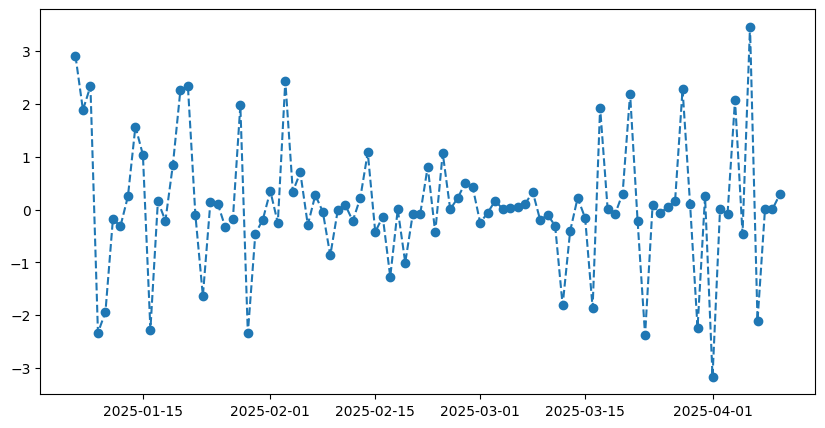

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(diff, marker='o', linestyle='--')
plt.show()

-------

In [92]:
df.columns = ['x']

In [128]:
df.tail()

,x
2025-04-06,1.199076
2025-04-07,-1.153166
2025-04-08,1.078350
2025-04-09,0.982654
2025-04-10,1.084168


In [131]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(df['x'], lags=2)
model_fit = model.fit()

model_fit.predict(start='2025-04-10', end='2025-06-10')

2025-04-10    0.655642
2025-04-11    0.658141
2025-04-12    0.632109
2025-04-13    0.608131
2025-04-14    0.605022
                ...   
2025-06-06    0.603157
2025-06-07    0.603157
2025-06-08    0.603157
2025-06-09    0.603157
2025-06-10    0.603157
Freq: D, Length: 62, dtype: float64

In [114]:
#### AUTO-REG

from sklearn.linear_model import LinearRegression

df_legend = pd.DataFrame({'Y_t': diff.values[2:].reshape(-1),
                         'Y_t-1': diff.shift(1).values[2:].reshape(-1),
                         'Y_t-2': diff.shift(2).values[2:].reshape(-1)}).dropna()

X = df_legend[['Y_t-1','Y_t-2']]
y = df_legend['Y_t']

model_ar = LinearRegression()
model_ar.fit(X, y)

print(model_ar.coef_)

[ 0.2009073  -0.51814597]


In [122]:
#### Moving Average


errors = np.random.normal(0, 1, len(diff))

df_ma = pd.DataFrame({'Y_t': diff.values[2:].reshape(-1),
                      'e_t-1': errors[1:-1],
                      'e_t-2': errors[:-2]}).dropna()

X_ma = df_ma[['e_t-1', 'e_t-2']]
y_ma = df_ma['Y_t']

model_ma = LinearRegression()
model_ma.fit(X_ma, y_ma)

LinearRegression()

In [123]:
print(f"Коэффициенты MA(q): {model_ma.coef_}")

Коэффициенты MA(q): [-0.20267132  0.09035681]


In [126]:
### Finnal Model ARIMA
###  AR(p) + I(d) + MA(q



def arima_predict(y_prev, error_prev, phi, theta, d):
    
    ar_part = sum(phi[i] * y_prev[i] for i in range(len(phi))) # AR(p)
    ma_part = sum(theta[i] * error_prev[i] for i in range(len(theta))) # MA(q)
    
    return ar_part + ma_part

Y_prev = diff.values # last 2 values
errors_prev = errors[-2:] # last 2 errors
phi = model_ar.coef_
theta = model_ma.coef_

next_value = arima_predict(Y_prev, errors_prev, phi, theta, d=1)
print('predict next value', next_value)

predict next value [-0.51683582]


-------------------------

In [64]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings
warnings.filterwarnings('ignore')


p = d = q = range(0, 3)

pdq = list(product(p, d, q))

best_aic = float('inf')
best_bic = float('inf')
best_order = None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        
        aic = model_fit.aic
        bic = model_fit.bic
        print(f'aic {aic:.3f}')
        print(f'bic {bic:.3f}')
        
        if aic < best_aic:
            best_aic = aic
            best_order = param
        if bic < best_bic:
            best_bic = bic
    except:
        continue
        
print(f'best param {best_order}')

aic 232.616
bic 237.615
aic 231.309
bic 238.809
aic 232.752
bic 242.752
aic 267.642
bic 270.131
aic 228.230
bic 233.208
aic 229.233
bic 236.699
aic 352.742
bic 355.219
aic 272.060
bic 277.014
aic 230.351
bic 237.783
aic 231.124
bic 238.624
aic 233.110
bic 243.109
aic 233.145
bic 245.644
aic 255.152
bic 260.129
aic 229.382
bic 236.848
aic 231.212
bic 241.166
aic 313.034
bic 317.989
aic 260.389
bic 267.821
aic 231.468
bic 241.377
aic 233.089
bic 243.088
aic 234.927
bic 247.426
aic 230.909
bic 245.908
aic 253.085
bic 260.551
aic 230.356
bic 240.310
aic 233.334
bic 245.777
aic 303.629
bic 311.061
aic 258.696
bic 268.605
aic 262.872
bic 275.258
best param (0, 1, 1)


In [65]:
print(train.tail())

print(test.tail(10))

                   0
2025-03-27  0.905019
2025-03-28  0.955526
2025-03-29  1.155125
2025-03-30 -1.105907
2025-03-31  1.250589
                   0
2025-04-01 -2.265360
2025-04-02  0.958158
2025-04-03  1.068675
2025-04-04  0.972678
2025-04-05  0.791174
2025-04-06  1.199076
2025-04-07 -1.153166
2025-04-08  1.078350
2025-04-09  0.982654
2025-04-10  1.084168


In [66]:
predict = model_fit.predict(start='2025-04-1', end='2025-04-10')

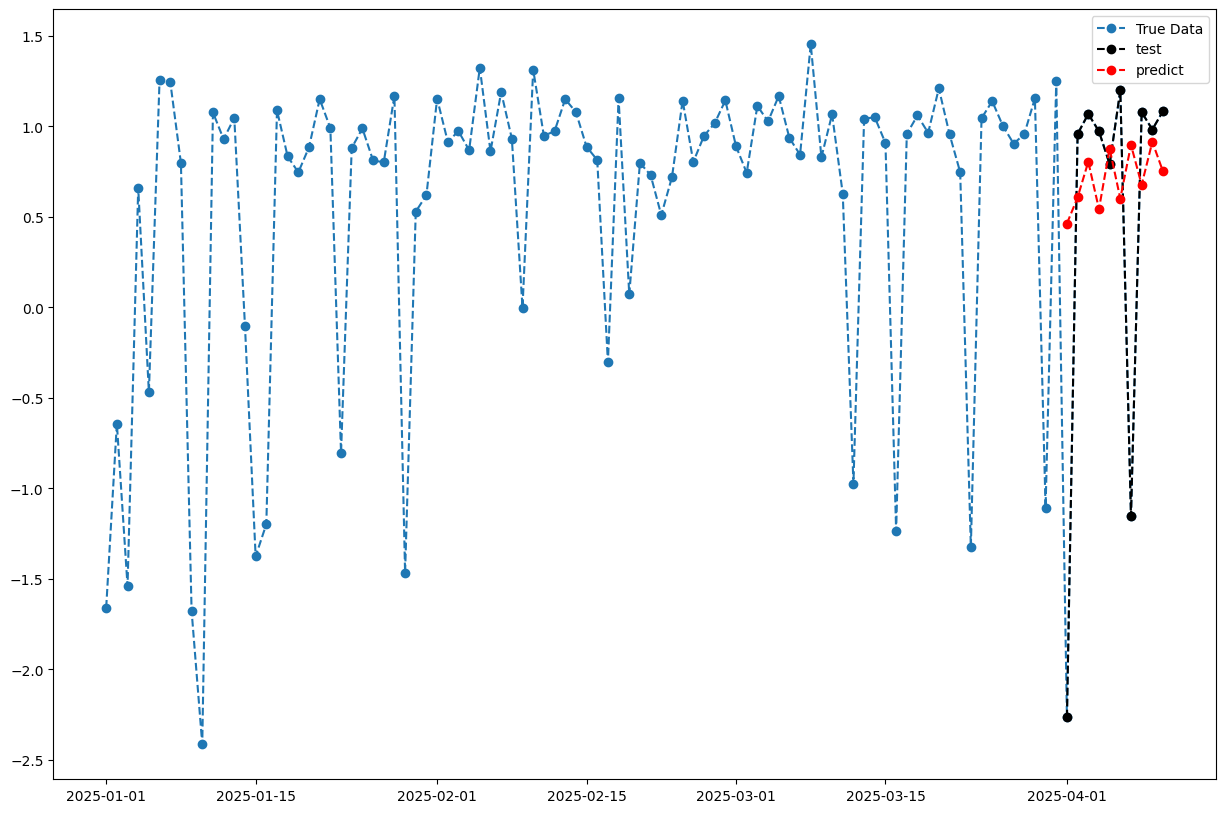

In [67]:
plt.figure(figsize=(15, 10))
plt.plot(df, marker='o', linestyle='--', label='True Data')
plt.plot(test,  marker='o', linestyle='--', c='black', label='test')
plt.plot(predict, marker='o', linestyle='--', c='red', label='predict')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(predict, test))

0.731014565516185


In [56]:
df.columns = ['x']

In [59]:
print(df.x.min())
print(df.x.max())
print(df.x.mean())

-2.413628983459218
1.453536683830305
0.5640475970924625
